# CHAPTER 3 - Classification

## MNIST

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [2]:
X, y = mnist["data"], mnist["target"]

X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it
using Matplotlib’s imshow() function:

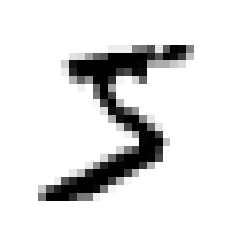

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [5]:
y[0]

'5'

This looks like a 5, and indeed that’s what the label tells us:

In [6]:
import numpy as np

y = y.astype(np.uint8)

But wait! You should always create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that
all cross-validation folds will be similar (you don’t want one fold to be missing some
digits). Moreover, some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen. But Shuffling may be a bad idea in some contexts—for example, if you are working on time series data (such as stock market prices or weather conditions). We will explore this in the next chapters.

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5:

In [10]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 ( True ). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. 

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, just as we did in Chapter 2.

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix. 

To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes ( y_train_5 ) and the predicted classes ( y_train_pred ):

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.

precision = TP / (TP + FP)

recall = TP / (TP + FN)

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) 


0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

As a result, the classifier will only get a high F1 score if both recall and precision are high.

To compute the F1 score, simply call the f1_score() function:

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846